# 1 Set up

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

## 1.1 Define Constants

In [7]:
base_path = r"C:\Users\bhuva\Documents\Workshop AI applications 5-2023\pneumonia-xray-images"
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')
valid_path = os.path.join(base_path, 'val')

In [8]:

#Define standard parameter values
batch_size = 16
img_height = 500
img_width = 500


# 2 Preparing Data

## 2.2 Image Data Augmentation

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                              
                               )  

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
                                      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [10]:
type(train)

keras.preprocessing.image.DirectoryIterator

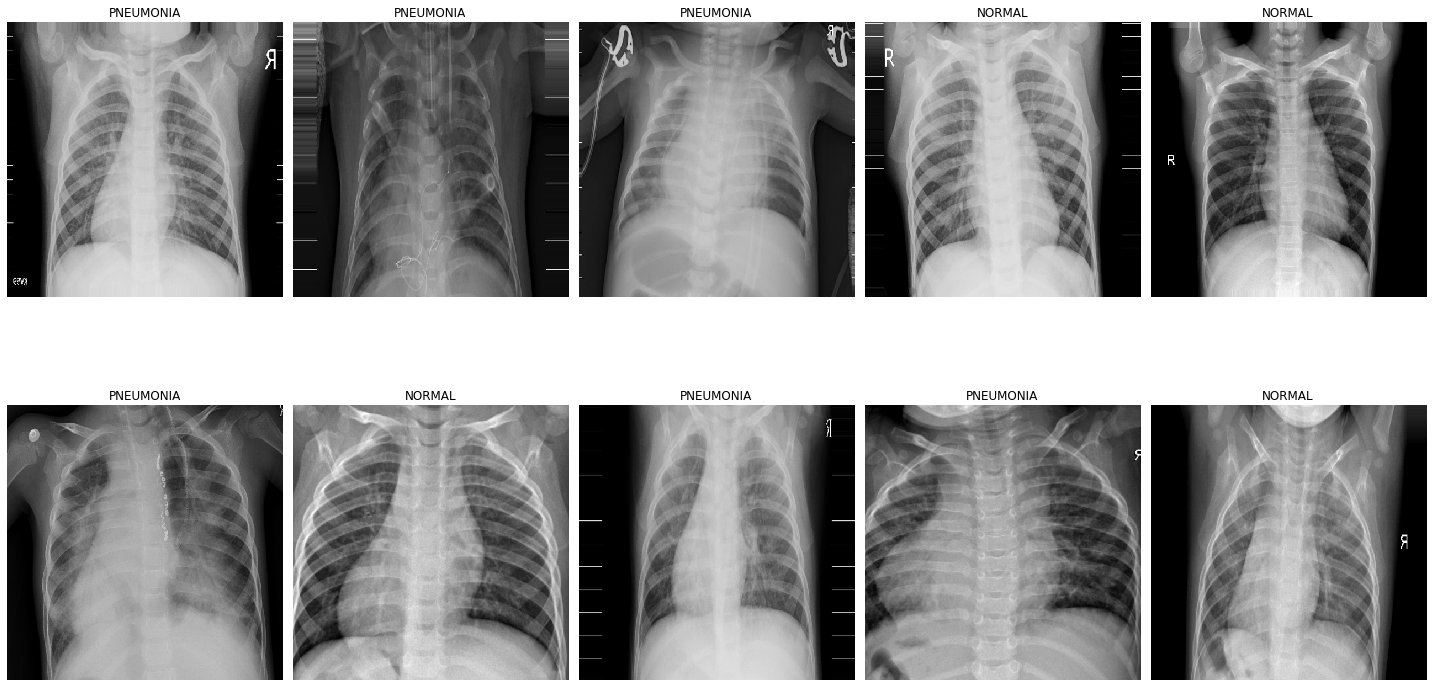

In [11]:
plt.figure(figsize=(20, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# 3 Tensorflow - Keras

In [12]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

## 3.1 Convolutional Neural Network Model

In [13]:
# let's build the CNN model

cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))


cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [14]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## 3.2 Fit Model

In [16]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [17]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train.classes), y=train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [ ]:
cnn.fit(train,epochs=5, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/5
262/262 [==============================] - 390s 1s/step - loss: 0.4093 - accuracy: 0.7886 - val_loss: 0.2549 - val_accuracy: 0.8923 - lr: 0.0010
Epoch 2/5
262/262 [==============================] - 386s 1s/step - loss: 0.2521 - accuracy: 0.8924 - val_loss: 0.3424 - val_accuracy: 0.8548 - lr: 0.0010
Epoch 3/5
262/262 [==============================] - 466s 2s/step - loss: 0.2254 - accuracy: 0.9039 - val_loss: 0.2174 - val_accuracy: 0.9183 - lr: 0.0010
Epoch 4/5
199/262 [=====================>........] - ETA: 1:26 - loss: 0.1969 - accuracy: 0.9187

In [ ]:
fp = "C:\Users\bhuva\Documents\Workshop AI applications 5-2023\pneumonia\cnn_pneu_vamp_model.h5"
#cnn.save(fp)

In [ ]:
cnn = load_model(fp)

In [ ]:
cnn.summary()
#cnn.predict_segmentation()

##3.3 Evaluation

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

In [ ]:
preds = cnn.predict(test,verbose=1)

In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
 print(classification_report(y_true=test.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

In [ ]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

In [ ]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
      
      

  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()